<a href="https://colab.research.google.com/github/selva101105/AI-group-project/blob/main/Grp28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern AI Techniques for Sentiment Classification: Naive Bayes on Twitter Data

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## Importing of file to Colab

In [ ]:
from google.colab import files
import io, pandas as pd, numpy as np, re
from sklearn.model_selection import train_test_split

uploaded = files.upload()
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Columns:", df.columns.tolist())
print(df.head(2))

text_candidates  = ['clean_text','text','tweet','content','review','message']
label_candidates = ['category','label','sentiment','target','polarity']

def pick_col(cands, cols):
    for c in cands:
        if c in cols: return c
    return None

tcol = pick_col(text_candidates, df.columns)
lcol = pick_col(label_candidates, df.columns)

if tcol is None or lcol is None:
    raise RuntimeError

df = df[[tcol, lcol]].rename(columns={tcol:'text', lcol:'label'})
df['text']  = df['text'].astype(str).fillna('')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label']).reset_index(drop=True).astype({'label':'int32'})

Saving Twitter_Data.csv to Twitter_Data.csv
Columns: ['clean_text', 'category']
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0


## Data Understanding

In [ ]:
df['label'].value_counts().sort_index()

,count
label,
-1,35510
0,55213
1,72250


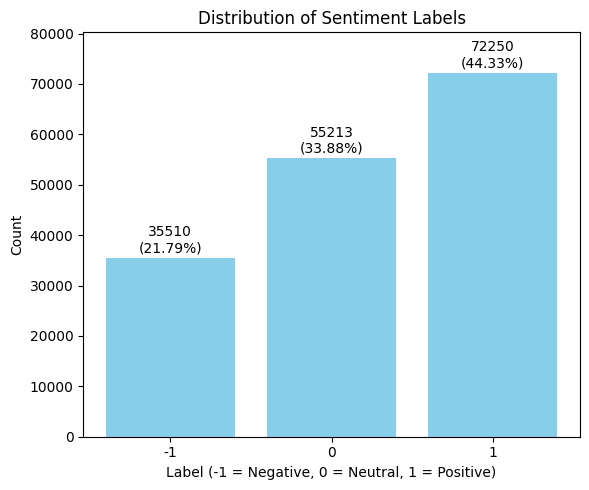

In [ ]:
import matplotlib.pyplot as plt

# Count labels and calculate percentages
label_counts = df['label'].value_counts().sort_index()
total = label_counts.sum()
percentages = (label_counts / total * 100).round(2)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')

# Add text labels (count + percentage)
for bar, pct, count in zip(bars, percentages, label_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f"{count}\n({pct}%)",
            ha='center', va='bottom', fontsize=10)

# Axis labels and title
ax.set_title("Distribution of Sentiment Labels")
ax.set_xlabel("Label (-1 = Negative, 0 = Neutral, 1 = Positive)")
ax.set_ylabel("Count")
plt.ylim(0, label_counts.max() + 8000)  # Leave space above bars
plt.tight_layout()
plt.show()


In [ ]:
df['char_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print("\nTweet length statistics:")
print(df[['char_length', 'word_count']].describe())


Tweet length statistics:
         char_length     word_count
count  162973.000000  162973.000000
mean      124.175348      20.080234
std        67.925849      10.879873
min         1.000000       0.000000
25%        66.000000      11.000000
50%       114.000000      18.000000
75%       183.000000      29.000000
max       274.000000      52.000000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(texts, n=15):
    vec = CountVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(texts)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).A1)
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

# Show top words for each class
for label in sorted(df['label'].unique()):
    print(f"\nTop words for label {label}:")
    top_words = get_top_words(df[df['label'] == label]['text'])
    for word, freq in top_words:
        print(f"{word:<12} {freq}")


Top words for label -1:
modi         35241
india        6346
people       4069
bjp          3619
like         3446
congress     3444
govt         2633
poor         2628
dont         2341
just         2319
money        1978
years        1959
hate         1930
narendra     1915
country      1897

Top words for label 0:
modi         49837
india        6727
narendra     4016
bjp          3977
congress     3568
vote         3055
like         3048
people       2873
modis        2625
govt         2496
dont         2252
election     2232
did          2100
just         1977
rahul        1959

Top words for label 1:
modi         70468
india        16080
bjp          7050
people       6954
like         6084
congress     5817
narendra     5535
govt         4896
good         4790
vote         4430
country      4393
nation       3975
just         3911
time         3846
dont         3812


## Data Preparation

In [ ]:
import html, unicodedata
from sklearn.model_selection import train_test_split

# Decontract function
def decontract(text):
    text = text.lower()
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

# Clean tweet function
def clean_tweet(s: str) -> str:
    s = str(s)
    s = html.unescape(s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode()
    s = decontract(s)                          # Expand contractions
    s = s.lower()                               # Lowercase everything
    s = re.sub(r'http\S+|www\.\S+', ' ', s)     # Remove URLs
    s = re.sub(r'@\w+', ' ', s)                 # Remove @mentions
    s = s.replace('#', ' ')                     # Remove hashtag symbol
    s = re.sub(r"[^\w\s':()\-\[\]]", " ", s)    # Remove most special chars
    s = re.sub(r'\w*\d\w*', '', s)              # Remove words with digits
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)        # Reduce character repetitions
    s = re.sub(r"\s+", " ", s).strip()          # Clean whitespace
    return s

#Apply cleaning to text column
df['text_clean'] = df['text'].map(clean_tweet)

In [ ]:
# show initial summary
print("Total rows:", len(df))
print("Unique cleaned texts:", df['text_clean'].nunique())
duplicate_count = len(df) - df['text_clean'].nunique()
print(f"Duplicate entries detected: {duplicate_count}")

#show duplicated rows (show *all* duplicates, not just the count)
duplicated_mask = df.duplicated(subset='text_clean', keep=False)
duplicated_rows = df[duplicated_mask]
print("Duplicated rows (showing both originals and duplicates):")
print(duplicated_rows[['text_clean', 'label']])

#show very short tweets
short_tweets = df[df['text_clean'].str.len() < 5]
print("\nVery short tweets (<5 chars):")
print(short_tweets[['text_clean', 'label']])

#drop duplicates and short tweets
df = df.drop_duplicates(subset='text_clean').reset_index(drop=True)
df = df[df['text_clean'].str.len() >= 5].reset_index(drop=True)
print("\nRows left after dropping duplicates and very short tweets:", len(df))

Total rows: 162973
Unique cleaned texts: 159280
Duplicate entries detected: 3693
Duplicated rows (showing both originals and duplicates):
                                               text_clean  label
6       surat women perform yagna seeks divine grace f...      0
13      one vote can make all the difference anil kapo...      0
32      modi govts slashing indias education budget cl...     -1
35                                              only modi      0
63      this new india this indias century because has...      1
...                                                   ...    ...
162727  yogi and modi are favor unemployed youth uttar...      1
162741  good for nothing bjp government and fakendra m...      1
162744                  modi all set return says nagaland      0
162805  award wapsi gang never returned any prize mone...      0
162832  inspired modis speech lata mangeshkar pays mov...      0

[6440 rows x 2 columns]

Very short tweets (<5 chars):
       text_clean  label
1

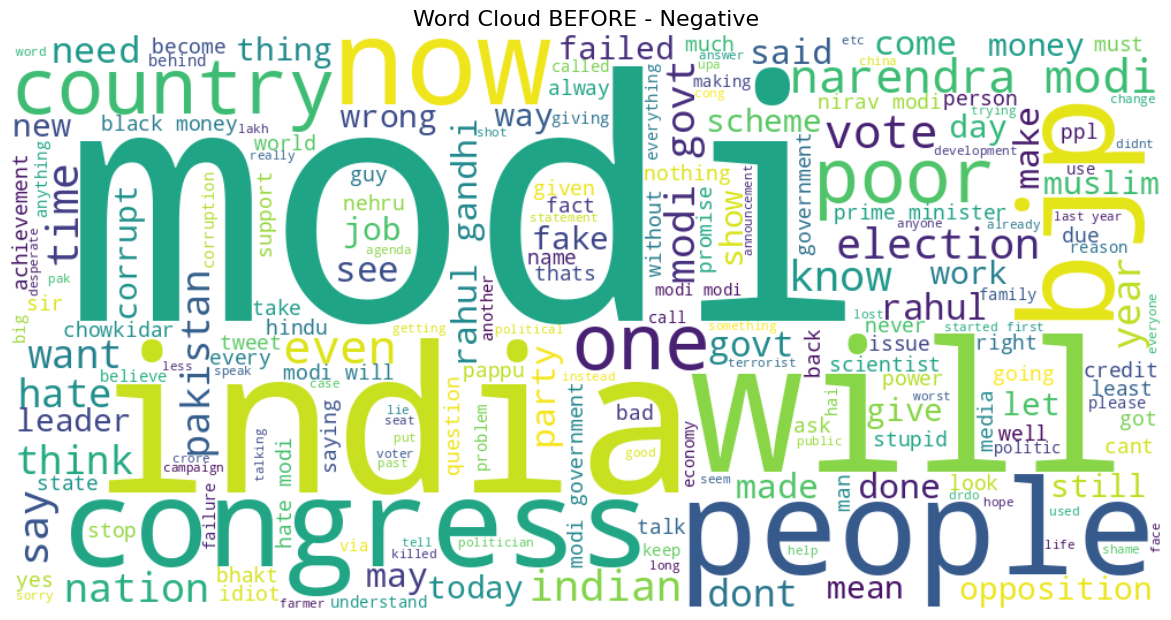

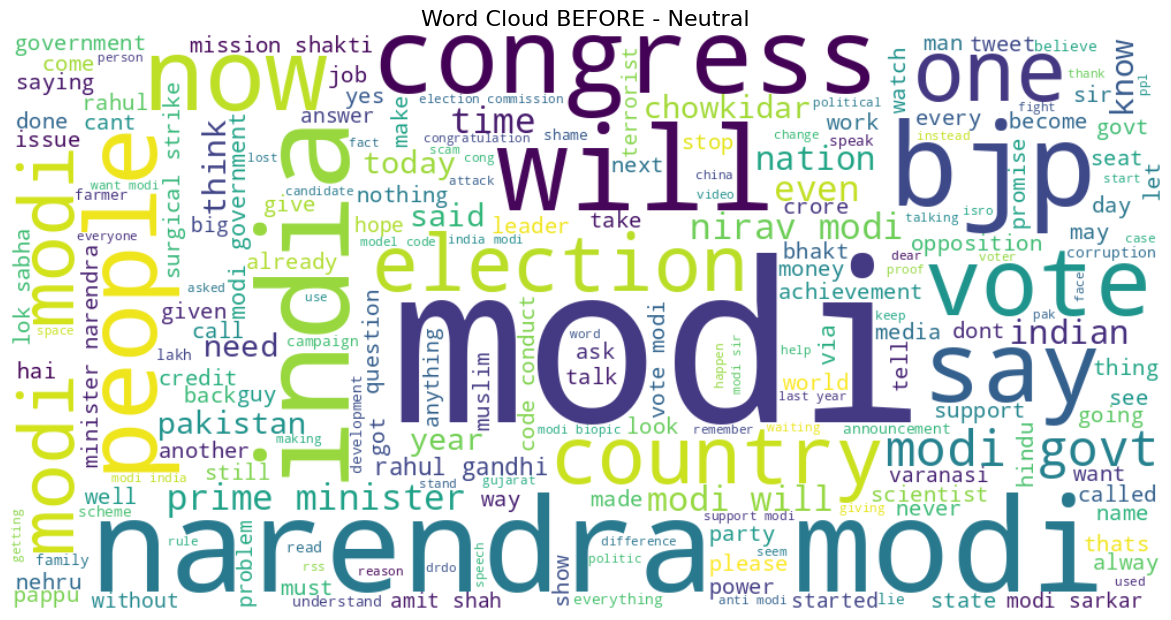

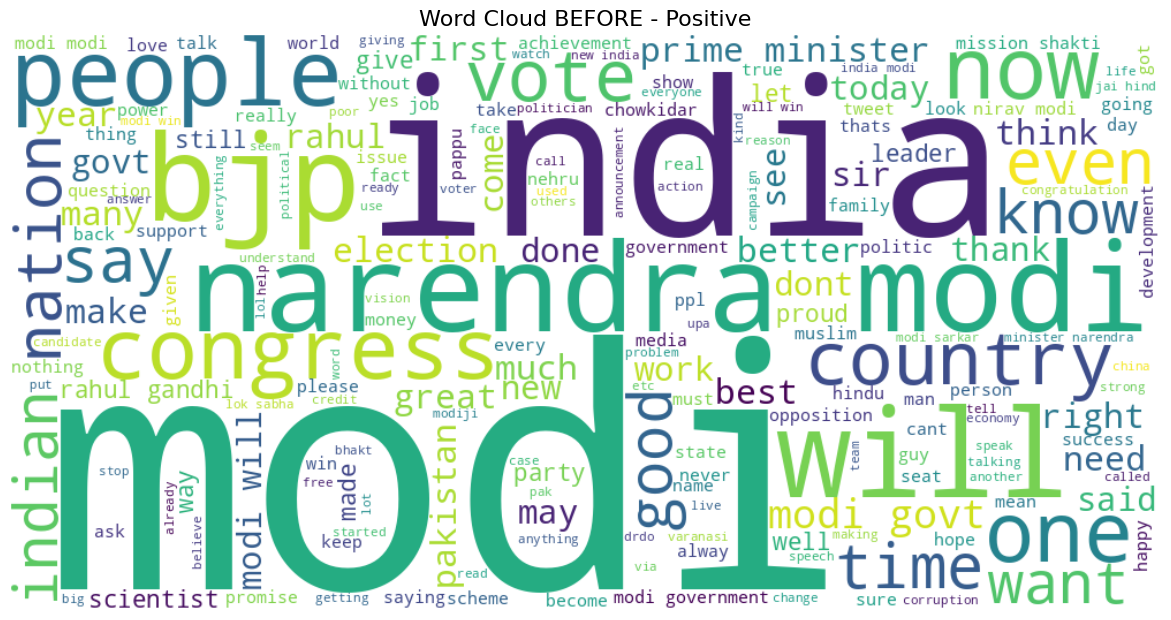

In [ ]:
from wordcloud import WordCloud
label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}

for label, label_name in label_map.items():
    text_data = " ".join(df[df['label'] == label]['text_clean'].astype(str))
    wordcloud = WordCloud(
        width=1000, height=500, background_color='white',
        max_words=200, colormap='viridis'
    ).generate(text_data)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud BEFORE - {label_name}", fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = [
    'modi', 'narendra', 'bjp', 'india', 'government', 'prime', 'minister',
    'rahul', 'election', 'campaign', 'vote', 'voting', 'party', 'congress',
    'support', 'supporter', 'politician', 'govt', 'leader',
    'national', 'today', 'people', 'will', 'can', 'should', 'dont', 'indian', 'year', 'one', 'like'
]
twitter_stopwords = [
    'retweet', 'rt', 'amp', 'plz', 'u', 'ur', 'im', 'lol', 'ya', 'oh', 'yeah'
]

extended_stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords).union(twitter_stopwords)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_and_filter(text):
    words = text.split()
    lemmatized = [
        lemmatizer.lemmatize(w, get_wordnet_pos(w))
        for w in words if w not in extended_stopwords
    ]
    return " ".join(lemmatized)

# If your 'text_clean' column might include NaN, fill empty first:
df['text_clean'] = df['text_clean'].fillna("")

# Now apply
df['text_final'] = df['text_clean'].map(lemmatize_and_filter)

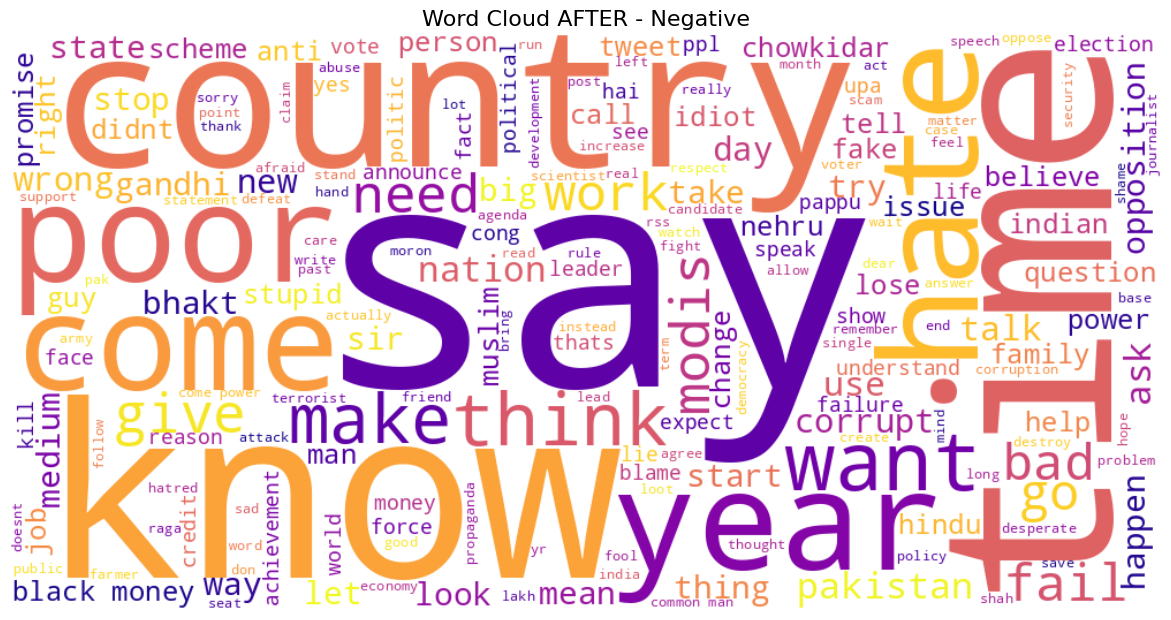

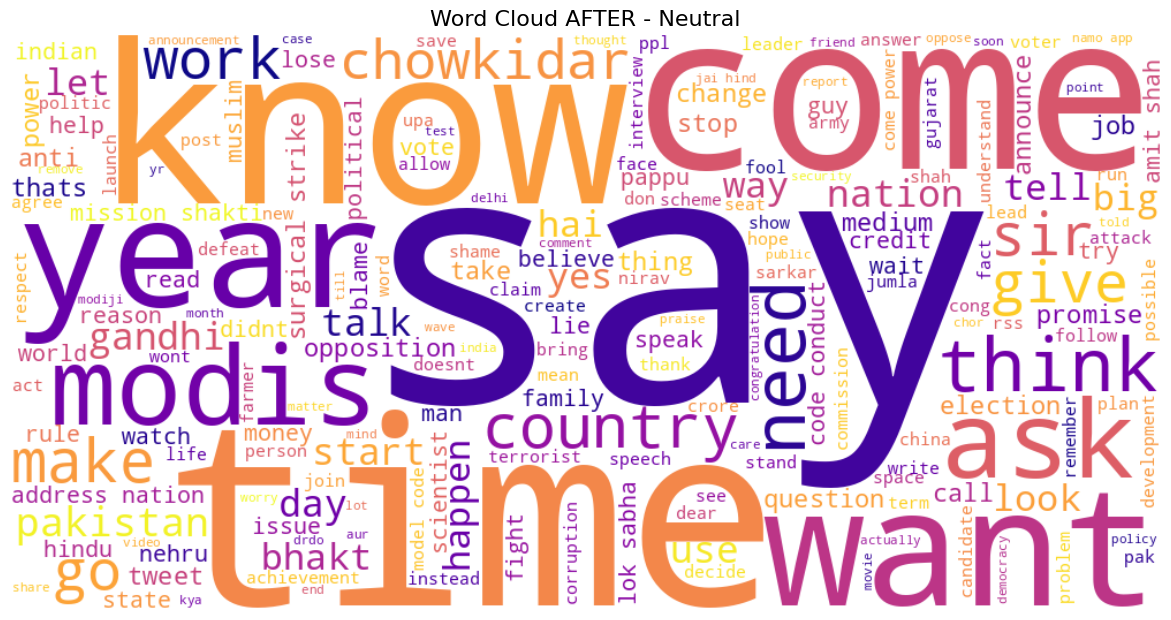

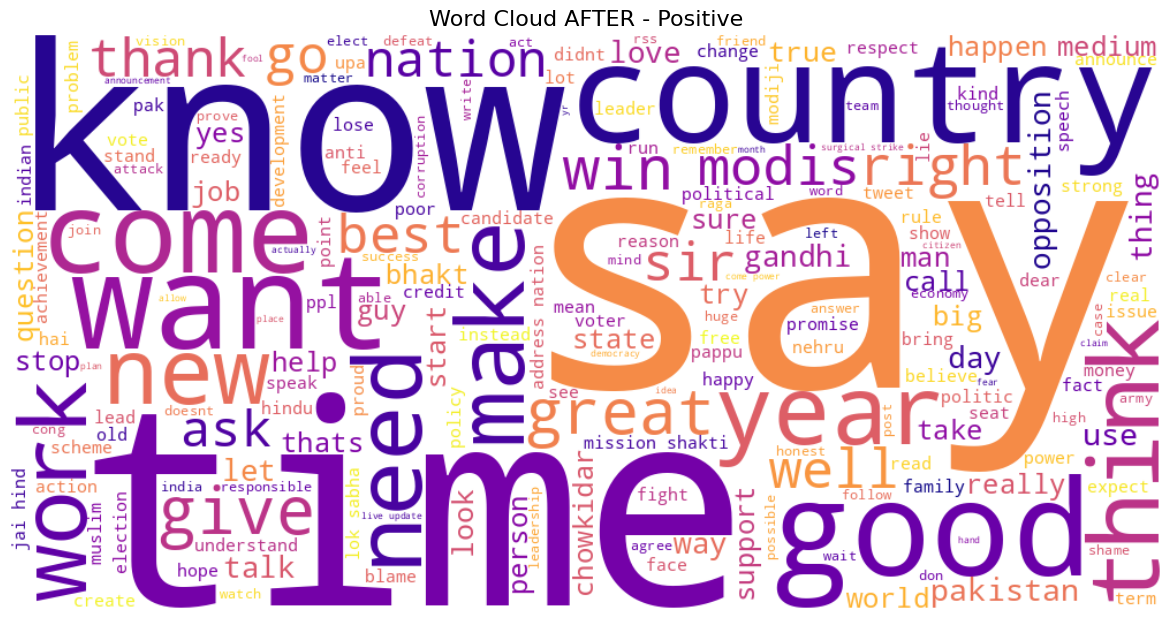

In [ ]:
for label, label_name in label_map.items():
    text_data_final = " ".join(df[df['label'] == label]['text_final'].astype(str))
    wordcloud_final = WordCloud(
        width=1000, height=500, background_color='white',
        max_words=200, colormap='plasma'
    ).generate(text_data_final)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_final, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud AFTER - {label_name}", fontsize=16)
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
import re

# 1. Define your word lists (expand as needed)
positive_words = [
    "good", "great", "happy", "love", "excellent", "success", "win", "best",
    "better", "awesome", "amazing", "positive", "thank", "enjoy", "hope",
    "nice", "wonderful", "brilliant", "strong", "improve", "support", "clear",
    "strong", "safe", "proud"
]

negative_words = [
    "bad", "sad", "hate", "worst", "angry", "poor", "problem", "fail",
    "failure", "corrupt", "fake", "stupid", "negative", "disappoint",
    "frustrate", "weak", "terrible", "wrong", "lose", "loser", "criticize",
    "danger", "fear", "risk", "attack"
]

neutral_words = [
    "say", "said", "think", "know", "time", "year", "country", "work",
    "public", "state", "policy", "scheme", "tweet", "medium", "tell",
    "new", "question", "issue", "candidate", "leader", "statement",
    "person", "team", "data", "fact"
]

# 2. Flag presence in cleaned tweets
df['has_positive'] = df['text_final'].apply(
    lambda x: bool(re.search(r"\b(" + "|".join(map(re.escape, positive_words)) + r")\b", x, re.IGNORECASE))
)

df['has_negative'] = df['text_final'].apply(
    lambda x: bool(re.search(r"\b(" + "|".join(map(re.escape, negative_words)) + r")\b", x, re.IGNORECASE))
)

df['has_neutral'] = df['text_final'].apply(
    lambda x: bool(re.search(r"\b(" + "|".join(map(re.escape, neutral_words)) + r")\b", x, re.IGNORECASE))
)

# 3. Print summary statistics for each flag
print(f"Percentage of tweets with positive words: {df['has_positive'].mean() * 100:.2f}%")
print(f"Percentage of tweets with negative words: {df['has_negative'].mean() * 100:.2f}%")
print(f"Percentage of tweets with neutral words: {df['has_neutral'].mean() * 100:.2f}%")


Percentage of tweets with positive words: 18.20%
Percentage of tweets with negative words: 14.08%
Percentage of tweets with neutral words: 42.03%


## Train Test Split

In [ ]:
X = df['text_final'].values
y = df['label'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test sizes:", len(y_train), len(y_test))


Train/Test sizes: 127356 31839


## Models (Before Data Balancing)

### MultinomialNB (Yee Shien)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score

vec_count = CountVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
Xtr_cnt = vec_count.fit_transform(X_train_text)
Xte_cnt = vec_count.transform(X_test_text)

mnb_cnt = MultinomialNB(alpha=1.0)
mnb_cnt.fit(Xtr_cnt, y_train)

pred_cnt = mnb_cnt.predict(Xte_cnt)
f1_cnt = f1_score(y_test, pred_cnt, average='macro')

print("CountVectorizer MultinomialNB")
print(classification_report(y_test, pred_cnt, digits=4))
print("Macro-F1:", round(f1_cnt, 4))

CountVectorizer MultinomialNB
              precision    recall  f1-score   support

          -1     0.6218    0.6788    0.6490      6977
           0     0.7354    0.5874    0.6531     10686
           1     0.6935    0.7674    0.7286     14176

    accuracy                         0.6876     31839
   macro avg     0.6836    0.6779    0.6769     31839
weighted avg     0.6919    0.6876    0.6858     31839

Macro-F1: 0.6769


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score

vec_tfidf = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
Xtr_tfidf = vec_tfidf.fit_transform(X_train_text)
Xte_tfidf = vec_tfidf.transform(X_test_text)

mnb_tfidf = MultinomialNB(alpha=1.0)
mnb_tfidf.fit(Xtr_tfidf, y_train)

pred_tfidf = mnb_tfidf.predict(Xte_tfidf)
f1_tfidf = f1_score(y_test, pred_tfidf, average='macro')

print("TF-IDF MultinomialNB")
print(classification_report(y_test, pred_tfidf, digits=4))
print("Macro-F1:", round(f1_tfidf, 4))

TF-IDF MultinomialNB
              precision    recall  f1-score   support

          -1     0.8142    0.3851    0.5229      6977
           0     0.7308    0.5292    0.6139     10686
           1     0.6030    0.8848    0.7172     14176

    accuracy                         0.6560     31839
   macro avg     0.7160    0.5997    0.6180     31839
weighted avg     0.6922    0.6560    0.6400     31839

Macro-F1: 0.618


Exploratory Data Analysis (EDA) — Label and Text Distribution

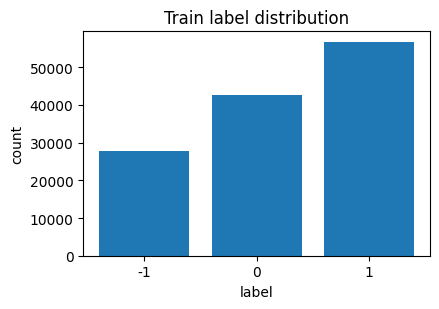

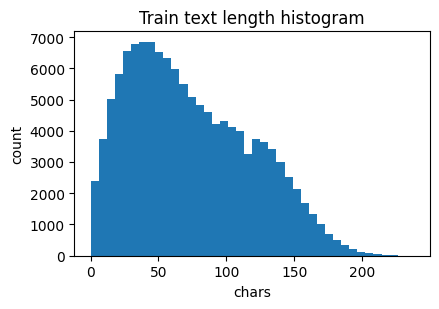

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

vals = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(4.5,3.2))
plt.bar(vals.index.astype(str), vals.values)
plt.title("Train label distribution")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout(); plt.show()

train_len = pd.Series([len(t) for t in X_train_text])
plt.figure(figsize=(4.5,3.2))
plt.hist(train_len, bins=40)
plt.title("Train text length histogram")
plt.xlabel("chars"); plt.ylabel("count")
plt.tight_layout(); plt.show()


###Logistic Regression (Nasiha)

In [ ]:
# LR CELL 1: (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

vec_count_lr = CountVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
Xtr_cnt_lr = vec_count_lr.fit_transform(X_train_text)
Xte_cnt_lr = vec_count_lr.transform(X_test_text)

lr_cnt = LogisticRegression(max_iter=2000, random_state=42)
lr_cnt.fit(Xtr_cnt_lr, y_train)

pred_cnt_lr = lr_cnt.predict(Xte_cnt_lr)
f1_cnt_lr = f1_score(y_test, pred_cnt_lr, average='macro')

print("CountVectorizer LogisticRegression")
print(classification_report(y_test, pred_cnt_lr, digits=4))
print("Macro-F1:", round(f1_cnt_lr, 4))


CountVectorizer LogisticRegression
              precision    recall  f1-score   support

          -1     0.8027    0.7346    0.7671      6977
           0     0.8039    0.9029    0.8505     10686
           1     0.8721    0.8276    0.8493     14176

    accuracy                         0.8325     31839
   macro avg     0.8262    0.8217    0.8223     31839
weighted avg     0.8340    0.8325    0.8317     31839

Macro-F1: 0.8223


In [ ]:
# LR CELL 2: (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

vec_tfidf_lr = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
Xtr_tfidf_lr = vec_tfidf_lr.fit_transform(X_train_text)
Xte_tfidf_lr = vec_tfidf_lr.transform(X_test_text)

lr_tfidf = LogisticRegression(max_iter=2000, random_state=42)
lr_tfidf.fit(Xtr_tfidf_lr, y_train)

pred_tfidf_lr = lr_tfidf.predict(Xte_tfidf_lr)
f1_tfidf_lr = f1_score(y_test, pred_tfidf_lr, average='macro')

print("TF-IDF LogisticRegression")
print(classification_report(y_test, pred_tfidf_lr, digits=4))
print("Macro-F1:", round(f1_tfidf_lr, 4))


TF-IDF LogisticRegression
              precision    recall  f1-score   support

          -1     0.8290    0.7020    0.7603      6977
           0     0.7831    0.9142    0.8436     10686
           1     0.8695    0.8253    0.8468     14176

    accuracy                         0.8281     31839
   macro avg     0.8272    0.8138    0.8169     31839
weighted avg     0.8316    0.8281    0.8268     31839

Macro-F1: 0.8169


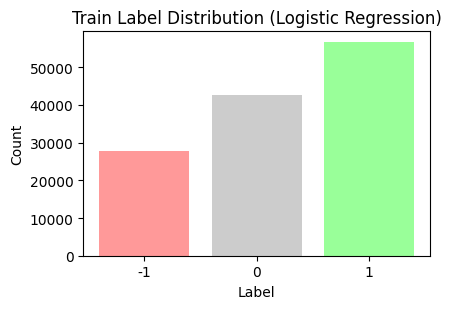

Label distribution:
Label -1: 27907 samples
Label 0: 42745 samples
Label 1: 56704 samples


In [ ]:
# LR CELL: Train Label Distribution
import pandas as pd
import matplotlib.pyplot as plt

vals = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(4.5,3.2))
plt.bar(vals.index.astype(str), vals.values, color=['#FF9999', '#CCCCCC', '#99FF99'])
plt.title("Train Label Distribution (Logistic Regression)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

print("Label distribution:")
for label, count in vals.items():
    print(f"Label {label}: {count} samples")


### Linear SVC (Selvambigai)

In [ ]:
# =====================
# SVC CELL 1: CountVectorizer + LinearSVC
# =====================

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

print(" Training LinearSVC with CountVectorizer...")

vec_count_svc = CountVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
Xtr_cnt_svc = vec_count_svc.fit_transform(X_train_text)
Xte_cnt_svc = vec_count_svc.transform(X_test_text)

svc_cnt = LinearSVC(random_state=42, max_iter=2000)
svc_cnt.fit(Xtr_cnt_svc, y_train)

pred_cnt_svc = svc_cnt.predict(Xte_cnt_svc)
f1_cnt_svc = f1_score(y_test, pred_cnt_svc, average='macro')

print("CountVectorizer LinearSVC")
print(classification_report(y_test, pred_cnt_svc, digits=4))
print("Macro-F1:", round(f1_cnt_svc, 4))

 Training LinearSVC with CountVectorizer...
CountVectorizer LinearSVC
              precision    recall  f1-score   support

          -1     0.7561    0.7265    0.7410      6977
           0     0.7953    0.8576    0.8253     10686
           1     0.8484    0.8147    0.8312     14176

    accuracy                         0.8098     31839
   macro avg     0.7999    0.7996    0.7992     31839
weighted avg     0.8104    0.8098    0.8095     31839

Macro-F1: 0.7992


In [ ]:
# =====================
# SVC CELL 2: TF-IDF + LinearSVC
# =====================

from sklearn.feature_extraction.text import TfidfVectorizer

print(" Training LinearSVC with TF-IDF...")

vec_tfidf_svc = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
Xtr_tfidf_svc = vec_tfidf_svc.fit_transform(X_train_text)
Xte_tfidf_svc = vec_tfidf_svc.transform(X_test_text)

svc_tfidf = LinearSVC(random_state=42, max_iter=2000)
svc_tfidf.fit(Xtr_tfidf_svc, y_train)

pred_tfidf_svc = svc_tfidf.predict(Xte_tfidf_svc)
f1_tfidf_svc = f1_score(y_test, pred_tfidf_svc, average='macro')

print("TF-IDF LinearSVC")
print(classification_report(y_test, pred_tfidf_svc, digits=4))
print("Macro-F1:", round(f1_tfidf_svc, 4))

 Training LinearSVC with TF-IDF...
TF-IDF LinearSVC
              precision    recall  f1-score   support

          -1     0.8058    0.7334    0.7679      6977
           0     0.8006    0.8947    0.8450     10686
           1     0.8667    0.8282    0.8470     14176

    accuracy                         0.8297     31839
   macro avg     0.8244    0.8188    0.8200     31839
weighted avg     0.8311    0.8297    0.8290     31839

Macro-F1: 0.82


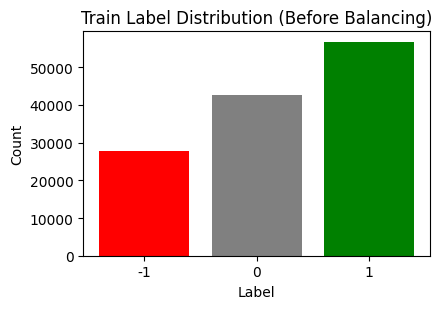

Label distribution:
Label -1: 27907 samples
Label 0: 42745 samples
Label 1: 56704 samples


In [ ]:
# =====================
# SVC CELL 6: Data Balancing Visualization
# =====================

import pandas as pd
import matplotlib.pyplot as plt

# Show current distribution
vals = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(4.5,3.2))
plt.bar(vals.index.astype(str), vals.values, color=['red', 'gray', 'green'])
plt.title("Train Label Distribution (Before Balancing)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

print("Label distribution:")
for label, count in vals.items():
    print(f"Label {label}: {count} samples")

### CNN (Jayne)

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report, f1_score

# Remap labels for Keras [must be 0-based for softmax]
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}
y_train_cnn = np.array([label_map[y] for y in y_train])
y_test_cnn = np.array([label_map[y] for y in y_test])

num_classes = 3

# One-hot encode for training
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes)

# Build CNN model
def build_cnn_model(num_classes, max_words=max_words, max_len=max_len):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("\nModel: CNN + Tokenizer (No Balancing)")
model_cnn = build_cnn_model(num_classes)
model_cnn.fit(X_train_pad, y_train_cnn_cat, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_cnn_cat), verbose=2)

pred_probs = model_cnn.predict(X_test_pad)
preds_cnn_code = np.argmax(pred_probs, axis=1)
# Remap predictions back to original sentiment
preds_cnn = [inv_label_map[x] for x in preds_cnn_code]

print(classification_report(y_test, preds_cnn, digits=4))
print("Macro-F1:", round(f1_score(y_test, preds_cnn, average='macro'), 4))

NameError: name 'max_words' is not defined

##Data Balancing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# ===============================
# CountVectorizer + Balancing
# ===============================
vec_count_bal = CountVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
X_train_count_bal = vec_count_bal.fit_transform(X_train_text)
X_test_count_bal  = vec_count_bal.transform(X_test_text)

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)

X_train_count_ros, y_train_count_ros = ros.fit_resample(X_train_count_bal, y_train)
X_train_count_rus, y_train_count_rus = rus.fit_resample(X_train_count_bal, y_train)

print(">>> CountVectorizer -- Class distributions")
print("Original:", pd.Series(y_train).value_counts())
print("RandomOverSampler:", pd.Series(y_train_count_ros).value_counts())
print("RandomUnderSampler:", pd.Series(y_train_count_rus).value_counts())

# ===============================
# TfidfVectorizer + Balancing
# ===============================
vec_tfidf_bal = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
X_train_tfidf_bal = vec_tfidf_bal.fit_transform(X_train_text)
X_test_tfidf_bal  = vec_tfidf_bal.transform(X_test_text)

X_train_tfidf_ros, y_train_tfidf_ros = ros.fit_resample(X_train_tfidf_bal, y_train)
X_train_tfidf_rus, y_train_tfidf_rus = rus.fit_resample(X_train_tfidf_bal, y_train)

print("\n>>> TfidfVectorizer -- Class distributions")
print("Original:", pd.Series(y_train).value_counts())
print("RandomOverSampler:", pd.Series(y_train_tfidf_ros).value_counts())
print("RandomUnderSampler:", pd.Series(y_train_tfidf_rus).value_counts())

# ===============================
# Tokenizer + Padding + Balancing
# ===============================
max_words = 40000
max_len = 100

tokenizer_bal = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_bal.fit_on_texts(X_train_text)
X_train_seq_bal = tokenizer_bal.texts_to_sequences(X_train_text)
X_test_seq_bal  = tokenizer_bal.texts_to_sequences(X_test_text)
X_train_pad_bal = pad_sequences(X_train_seq_bal, maxlen=max_len)
X_test_pad_bal  = pad_sequences(X_test_seq_bal, maxlen=max_len)

X_train_pad_ros, y_train_pad_ros = ros.fit_resample(X_train_pad_bal, y_train)
X_train_pad_rus, y_train_pad_rus = rus.fit_resample(X_train_pad_bal, y_train)

print("\n>>> Tokenizer+Pad -- Class distributions")
print("Original:", pd.Series(y_train).value_counts())
print("RandomOverSampler:", pd.Series(y_train_pad_ros).value_counts())
print("RandomUnderSampler:", pd.Series(y_train_pad_rus).value_counts())

# ===============================
# Model Fitting & Evaluation
# ===============================
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}
num_classes = 3

# Fit and evaluate classical models
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
    "LinearSVC": LinearSVC(max_iter=2000, random_state=42)
}

for feat_type, X_train, X_test, y_train_bal in [
    # Classical
    ("CountVectorizer-ROS", X_train_count_ros, X_test_count_bal, y_train_count_ros),
    ("CountVectorizer-RUS", X_train_count_rus, X_test_count_bal, y_train_count_rus),
    ("TfidfVectorizer-ROS", X_train_tfidf_ros, X_test_tfidf_bal, y_train_tfidf_ros),
    ("TfidfVectorizer-RUS", X_train_tfidf_rus, X_test_tfidf_bal, y_train_tfidf_rus),
]:
    print(f"\n===== Feature: {feat_type} =====")
    for model_name, model in models.items():
        model.fit(X_train, y_train_bal)
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds, average='macro')
        print(f"\nModel: {model_name}")
        print(classification_report(y_test, preds, digits=4))
        print("Macro-F1:", round(f1, 4))

# Fit and evaluate CNN (Tokenizer+Pad+Balancing)
for feat_type, X_train_tok, X_test_tok, y_train_tok in [
    ("TokenizerPad-ROS", X_train_pad_ros, X_test_pad_bal, y_train_pad_ros),
    ("TokenizerPad-RUS", X_train_pad_rus, X_test_pad_bal, y_train_pad_rus),
]:
    print(f"\n===== Feature: {feat_type} =====")
    y_train_map = np.array([label_map[y] for y in y_train_tok])
    y_test_map = np.array([label_map[y] for y in y_test])
    y_train_cat = to_categorical(y_train_map, num_classes)
    y_test_cat = to_categorical(y_test_map, num_classes)

    def build_cnn_model():
        model = Sequential([
            Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    print(f"\nModel: CNN")
    model_cnn = build_cnn_model()
    model_cnn.fit(X_train_tok, y_train_cat, epochs=5, batch_size=64, validation_data=(X_test_tok, y_test_cat), verbose=2)
    pred_probs = model_cnn.predict(X_test_tok)
    preds_cnn_code = np.argmax(pred_probs, axis=1)
    preds_cnn = [inv_label_map[x] for x in preds_cnn_code]
    print(classification_report(y_test, preds_cnn, digits=4))
    print("Macro-F1:", round(f1_score(y_test, preds_cnn, average='macro'), 4))

## **Grid Search**

### Multi Nomial

In [ ]:
# GridSearchCV with TF-IDF + RandomOverSampler + MultinomialNB
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

# Pipeline: TF-IDF → ROS → NB
pipe_ros = ImbPipeline(steps=[
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=2)),
    ('ros',   RandomOverSampler(random_state=42)),
    ('nb',    MultinomialNB())
])

param_grid = {
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range':  [(1,1), (1,2)],
    'nb__alpha':           [0.3, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs_ros = GridSearchCV(
    estimator=pipe_ros,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit using raw text — pipeline handles vectorization & oversampling inside CV
gs_ros.fit(X_train_text, y_train)

print("Best params:", gs_ros.best_params_)
print("Best CV macro-F1:", round(gs_ros.best_score_, 4))

# Evaluate on test data
best_ros = gs_ros.best_estimator_
y_pred = best_ros.predict(X_test_text)
print("\nClassification report on test data:")
print(classification_report(y_test, y_pred, digits=4))
print("Test macro-F1:", round(f1_score(y_test, y_pred, average='macro'), 4))


*Model Evaluation and Confusion Matrix*

In [ ]:
# Confusion Matrix for TF-IDF (MultinomialNB)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm_tfidf = confusion_matrix(y_test, pred_tfidf, labels=[-1, 0, 1])
print("Confusion matrix (TF-IDF):\n", cm_tfidf)

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm_tfidf, cmap='Blues')
ax.set_title('TF-IDF MultinomialNB')
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2])
ax.set_xticklabels([-1, 0, 1]); ax.set_yticklabels([-1, 0, 1])

for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_tfidf[i, j], ha='center', va='center', color='black')

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
## DONE FOR AFTER BALANCING
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_test, classes=[-1,0,1])
proba = mnb_tfidf.predict_proba(Xte_tfidf)
fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TF-IDF + MultinomialNB)')
plt.legend()
plt.show()

In [ ]:
# DONE FOR AFTER BALANCING
y_test_np = y_test.values if hasattr(y_test, 'values') else np.asarray(y_test)
X_test_arr = X_test_text.values if hasattr(X_test_text, 'values') else np.asarray(X_test_text)

mis_idx = np.where(y_test_np != best_pred)[0]
print(f"Misclassified examples: {len(mis_idx)} (showing first 10)\n")
for i in mis_idx[:10]:
    print(f"- {X_test_arr[i]}")
    print(f"  true={y_test_np[i]}, pred={best_pred[i]}\n")

In [ ]:
# MultinomialNB (Confidence Distribution)
Xte_best = best_vec.transform(X_test_text)
proba = best_mnb.predict_proba(Xte_best).max(axis=1)

plt.figure(figsize=(4.8,3.2))
plt.hist(proba, bins=20, color='lightblue')
plt.title(f"Confidence Distribution ({best_name} + MultinomialNB)")
plt.xlabel("max probability"); plt.ylabel("count")
plt.tight_layout()
plt.show()

### Logistic Regression

In [ ]:
# GridSearchCV with TF-IDF + RandomOverSampler + LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

pipe_ros_lr = ImbPipeline(steps=[
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=2)),
    ('ros',   RandomOverSampler(random_state=42)),
    ('clf',   LogisticRegression(max_iter=2000, random_state=42, solver='saga', multi_class='multinomial'))
])

param_grid_lr = {
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range':  [(1,1), (1,2)],
    'clf__C':              [0.01, 0.1, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs_ros_lr = GridSearchCV(
    estimator=pipe_ros_lr,
    param_grid=param_grid_lr,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("Running GridSearch for Logistic Regression (TF-IDF + ROS)...")
gs_ros_lr.fit(X_train_text, y_train)

print("Best params (LR):", gs_ros_lr.best_params_)
print("Best CV macro-F1 (LR):", round(gs_ros_lr.best_score_, 4))

# Evaluate on test
best_lr = gs_ros_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_text)
print("\nLogistic Regression - Classification report on test data:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("Test macro-F1 (LR):", round(f1_score(y_test, y_pred_lr, average='macro'), 4))


In [ ]:
# LR CELL 5: (Model Evaluation and Confusion Matrix - TF-IDF only)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# For TF-IDF
cm_tfidf_lr = confusion_matrix(y_test, pred_tfidf_lr, labels=[-1, 0, 1])
print("Confusion matrix (TF-IDF):\n", cm_tfidf_lr)

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm_tfidf_lr, cmap='Blues')
ax.set_title('TF-IDF Logistic Regression')
ax.set_xticks([0, 1, 2]); ax.set_yticks([0, 1, 2])
ax.set_xticklabels([-1, 0, 1]); ax.set_yticklabels([-1, 0, 1])

# Add text annotations
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_tfidf_lr[i, j], ha='center', va='center', color='black')

ax.set_xlabel("Predicted");
ax.set_ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# LR CELL 9: (ROC Curve)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for multiclass ROC
y_bin_lr = label_binarize(y_test, classes=sorted(np.unique(y_test)))  # e.g. [-1,0,1]
proba_lr_full = lr_tfidf.predict_proba(Xte_tfidf_lr)  # use tfidf model proba for ROC

fpr, tpr, _ = roc_curve(y_bin_lr.ravel(), proba_lr_full.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TF-IDF + LogisticRegression)')
plt.legend(); plt.show()


In [ ]:
# LR CELL 6: (Misclassified examples) — DONE AFTER BALANCING
import numpy as np

# use best_pred_lr from the chosen best setting
y_test_np = y_test.values if hasattr(y_test, 'values') else np.asarray(y_test)
X_test_arr = X_test_text.values if hasattr(X_test_text, 'values') else np.asarray(X_test_text)

mis_idx_lr = np.where(y_test_np != best_pred_lr)[0]
print(f"Misclassified examples: {len(mis_idx_lr)} (showing first 10)\n")
for i in mis_idx_lr[:10]:
    print(f"- {X_test_arr[i]}")
    print(f"  true={y_test_np[i]}, pred={best_pred_lr[i]}\n")


In [ ]:
# LR CELL 7: (Confidence Distribution)
import matplotlib.pyplot as plt
import numpy as np

Xte_best_lr = best_vec_lr.transform(X_test_text)
# logistic Regression supports predict_proba
proba_lr = best_lr.predict_proba(Xte_best_lr).max(axis=1)

plt.figure(figsize=(4.8,3.2))
plt.hist(proba_lr, bins=20, color='lightgreen')
plt.title(f"Confidence Distribution ({best_name_lr} + LogisticRegression)")
plt.xlabel("max probability"); plt.ylabel("count")
plt.tight_layout()
plt.show()


### Linear SVC

In [ ]:
# GridSearchCV with TF-IDF + RandomOverSampler + LinearSVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

pipe_ros_svm = ImbPipeline(steps=[
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=2)),
    ('ros',   RandomOverSampler(random_state=42)),
    ('clf',   LinearSVC(max_iter=10000, random_state=42))
])

param_grid_svm = {
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range':  [(1,1), (1,2)],
    'clf__C':              [0.01, 0.1, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs_ros_svm = GridSearchCV(
    estimator=pipe_ros_svm,
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("Running GridSearch for LinearSVC (TF-IDF + ROS)...")
gs_ros_svm.fit(X_train_text, y_train)

print("Best params (SVM):", gs_ros_svm.best_params_)
print("Best CV macro-F1 (SVM):", round(gs_ros_svm.best_score_, 4))

# Evaluate on test
best_svm = gs_ros_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_text)
print("\nLinearSVC - Classification report on test data:")
print(classification_report(y_test, y_pred_svm, digits=4))
print("Test macro-F1 (SVM):", round(f1_score(y_test, y_pred_svm, average='macro'), 4))


In [ ]:
# =====================
# SVC CELL 5: Model Evaluation & Confusion Matrix (TF-IDF only)
# =====================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# For TF-IDF
cm_tfidf_svc = confusion_matrix(y_test, pred_tfidf_svc, labels=[-1, 0, 1])
print("Confusion matrix (TF-IDF LinearSVC):\n", cm_tfidf_svc)

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm_tfidf_svc, cmap='Reds')
ax.set_title('TF-IDF LinearSVC')
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels([-1, 0, 1])
ax.set_yticklabels([-1, 0, 1])

for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_tfidf_svc[i, j], ha='center', va='center', color='black')

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# =====================
# SVC CELL 9: ROC Curve
# =====================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for multiclass ROC
y_bin_svc = label_binarize(y_test, classes=sorted(np.unique(y_test)))

# LinearSVC doesn't have predict_proba, so we use decision_function
decision_scores_full = svc_tfidf.decision_function(Xte_tfidf_svc)

# For ROC, we need to handle the multi-class case
fpr, tpr, _ = roc_curve(y_bin_svc.ravel(), decision_scores_full.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', linewidth=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TF-IDF + LinearSVC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# =====================
# SVC CELL 7: Misclassified Examples
# =====================

import pandas as pd

# Create results dataframe with best SVC model
svc_results_df = pd.DataFrame({
    'text': X_test_text,
    'true': y_test,
    'pred': best_pred_svc,
    'correct': y_test == best_pred_svc
})

# Show misclassified examples
misclassified_svc = svc_results_df[~svc_results_df['correct']]
print(f"Total misclassified by LinearSVC: {len(misclassified_svc)}")
print(f"Accuracy: {(len(svc_results_df) - len(misclassified_svc)) / len(svc_results_df) * 100:.2f}%")

print("\nSample misclassified examples:")
for idx, row in misclassified_svc.head(10).iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"True: {row['true']} ({label_name[row['true']]}), Predicted: {row['pred']} ({label_name[row['pred']]})")

In [ ]:
# =====================
# SVC CELL 7: Confidence Distribution
# =====================

import matplotlib.pyplot as plt
import numpy as np

# LinearSVC doesn't have predict_proba, but we can use decision_function
Xte_best_svc = best_vec_svc.transform(X_test_text)
decision_scores = best_svc.decision_function(Xte_best_svc)

# For multi-class, get max decision score as confidence measure
confidence_svc = np.max(decision_scores, axis=1)

plt.figure(figsize=(4.8,3.2))
plt.hist(confidence_svc, bins=20, color='lightcoral', alpha=0.7)
plt.title(f"Confidence Distribution ({best_name_svc} + LinearSVC)")
plt.xlabel("Max Decision Score"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Average confidence: {np.mean(confidence_svc):.4f}")
print(f"Confidence std: {np.std(confidence_svc):.4f}")

### CNN

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, f1_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# ---- PREPARE LABELS FOR KERAS ---- #
label_map = {-1: 0, 0: 1, 1: 2}
inv_label_map = {0: -1, 1: 0, 2: 1}
y_train_cnn = np.array([label_map[y] for y in y_train])
y_test_cnn = np.array([label_map[y] for y in y_test])

max_words = 40000
max_len = 100
num_classes = 3

def build_cnn(num_filters=128, kernel_size=5, dense_units=64, dropout_rate=0.5, **kwargs):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
        Conv1D(num_filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_est = KerasClassifier(
    model=build_cnn,
    epochs=5,         # Will be tuned
    batch_size=64,    # Will be tuned
    verbose=0,
    return_history=True,
    validation_split = 0.1
)

pipe_cnn_ros = ImbPipeline([
    ('ros', RandomOverSampler(random_state=42)),
    ('cnn', cnn_est)
])

param_dist_cnn = {
    "cnn__model__num_filters": [64, 128],
    "cnn__model__kernel_size": [3, 5],
    "cnn__model__dense_units": [64, 128],
    "cnn__model__dropout_rate": [0.3, 0.5],
    "cnn__epochs": [3, 5],
    "cnn__batch_size": [32, 64]
}

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs_cnn_ros = RandomizedSearchCV(
    estimator=pipe_cnn_ros,
    param_distributions=param_dist_cnn,
    n_iter=10,               # Try 10 random combinations (customize as desired)
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'      # Show full errors
)

# ---- FITTING MODEL ---- #
rs_cnn_ros.fit(X_train_pad, y_train_cnn)

print("Best params:", rs_cnn_ros.best_params_)
print("Best CV accuracy:", round(rs_cnn_ros.best_score_, 4))

# ---- EVALUATE ON TEST DATA ---- #
best_cnn_ros = rs_cnn_ros.best_estimator_
y_pred_cnn_code = best_cnn_ros.predict(X_test_pad)
y_pred_cnn = [inv_label_map[x] for x in y_pred_cnn_code]
print("\nClassification report on test data:")
print(classification_report(y_test, y_pred_cnn, digits=4))
print("Test macro-F1:", round(f1_score(y_test, y_pred_cnn, average='macro'), 4))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_cnn, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Neg", "Neutral", "Pos"],
            yticklabels=["Neg", "Neutral", "Pos"], cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

cnn_clf = best_cnn_ros.named_steps['cnn']
history = None

if hasattr(cnn_clf, "model_"):
    if hasattr(cnn_clf.model_, "history_"):
        history = cnn_clf.model_.history_
    elif hasattr(cnn_clf, "history_"):
        history = cnn_clf.history_

if history is not None:
    # Now history is a dict, so access directly
    if 'accuracy' in history:
        plt.plot(history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('CNN Learning Curve (Accuracy vs Epoch)')
    plt.legend()
    plt.show()
else:
    print("[Warning] No training history found in best_cnn_ros.named_steps['cnn'].model_.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Step 1: Binarize test labels to one-hot ---
# Your original y_test is e.g. [-1, 0, 1], use the same label_map as in your code
classes = [-1, 0, 1]
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# --- Step 2: Get predicted probabilities (from pipeline, which is best_cnn_ros) ---
# This will give you an (n_samples, n_classes) array
y_score = best_cnn_ros.predict_proba(X_test_pad)

# --- Step 3: Compute ROC curve and ROC area for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 4: Plot all ROC curves (one vs rest) ---
plt.figure(figsize=(8, 6))
class_names = ['Negative', 'Neutral', 'Positive']  # order matches class label mapping [-1, 0, 1]
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], lw=2,
        label=f"ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for CNN (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ----- Misclassified Examples (text, true/pred/confidence) -----
# Make sure X_test_text is aligned with X_test_pad/y_test
proba = best_cnn_ros.named_steps['cnn'].predict_proba(X_test_pad)
mis_idx = np.where(np.array(y_test) != np.array(y_pred_cnn))[0]
print("--- Misclassified Examples ---")
for idx in mis_idx[:10]:  # Show first 3
    print(f"Text: {X_test_text[idx]}")  # Assumes X_test_text is test texts, same index order as X_test_pad
    print(f"True Label: {y_test[idx]}, Predicted: {y_pred_cnn[idx]}, Confidence: {np.max(proba[idx]):.4f}\n")

In [ ]:
# ----- Confidence Distribution (for predicted class) -----
max_confidences = np.max(proba, axis=1)
plt.hist(max_confidences, bins=20, color="purple", alpha=0.7)
plt.xlabel("Predicted Class Confidence")
plt.ylabel("Number of Samples")
plt.title("CNN Confidence Distribution")
plt.show()

## Sample prediction using CNN model:

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import pad_sequences

inv_label_map = {0: -1, 1: 0, 2: 1}
label_text_map = {-1: "negative", 0: "neutral", 1: "positive"}

def predict_sent_cnn(texts):
    """
    Predict sentiment and softmax confidence for new texts using trained CNN pipeline.
    Returns a DataFrame: text, pred (sentiment as string), confidence.
    """
    if isinstance(texts, str):
        texts = [texts]

    cleaned = [clean_tweet(t) for t in texts]
    seqs = tokenizer.texts_to_sequences(cleaned)
    X_pad = pad_sequences(seqs, maxlen=max_len, padding='post')

    pred_codes = best_cnn_ros.predict(X_pad)
    pred_labels = [inv_label_map[int(x)] for x in pred_codes]
    sentiments = [label_text_map[y] for y in pred_labels]
    proba = best_cnn_ros.predict_proba(X_pad)
    confidence = np.max(proba, axis=1)

    return pd.DataFrame({
        'text': texts,
        'pred': sentiments,
        'confidence': confidence.round(4)
    })

# ---------- Example usage: ----------
result = predict_sent_cnn([
    "Works as expected.",
    "Great job on the project",
    "it can be better."
])
print(result)